In [1]:
import pandas as pd
import numpy as np 
import feather
import os as os
#os.environ["PROJ_LIB"] = "/Users/john/miniconda3/share/proj"; #fixr
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
#import glob
%matplotlib inline
import cartopy.crs as ccrs

In [7]:
dat2 = pd.read_feather('~/Data/GFW_point/Patagonia_Shelf/feather/2016-01-03.feather')
print(dat2.columns)

Index(['timestamp', 'vessel_A', 'vessel_B', 'vessel_A_lat', 'vessel_A_lon',
       'vessel_B_lat', 'vessel_B_lon', 'rank', 'distance'],
      dtype='object')


In [1]:
#print(sorted(dat2.distance_from_shore_m.unique()))

AttributeError: 'DataFrame' object has no attribute 'lon'

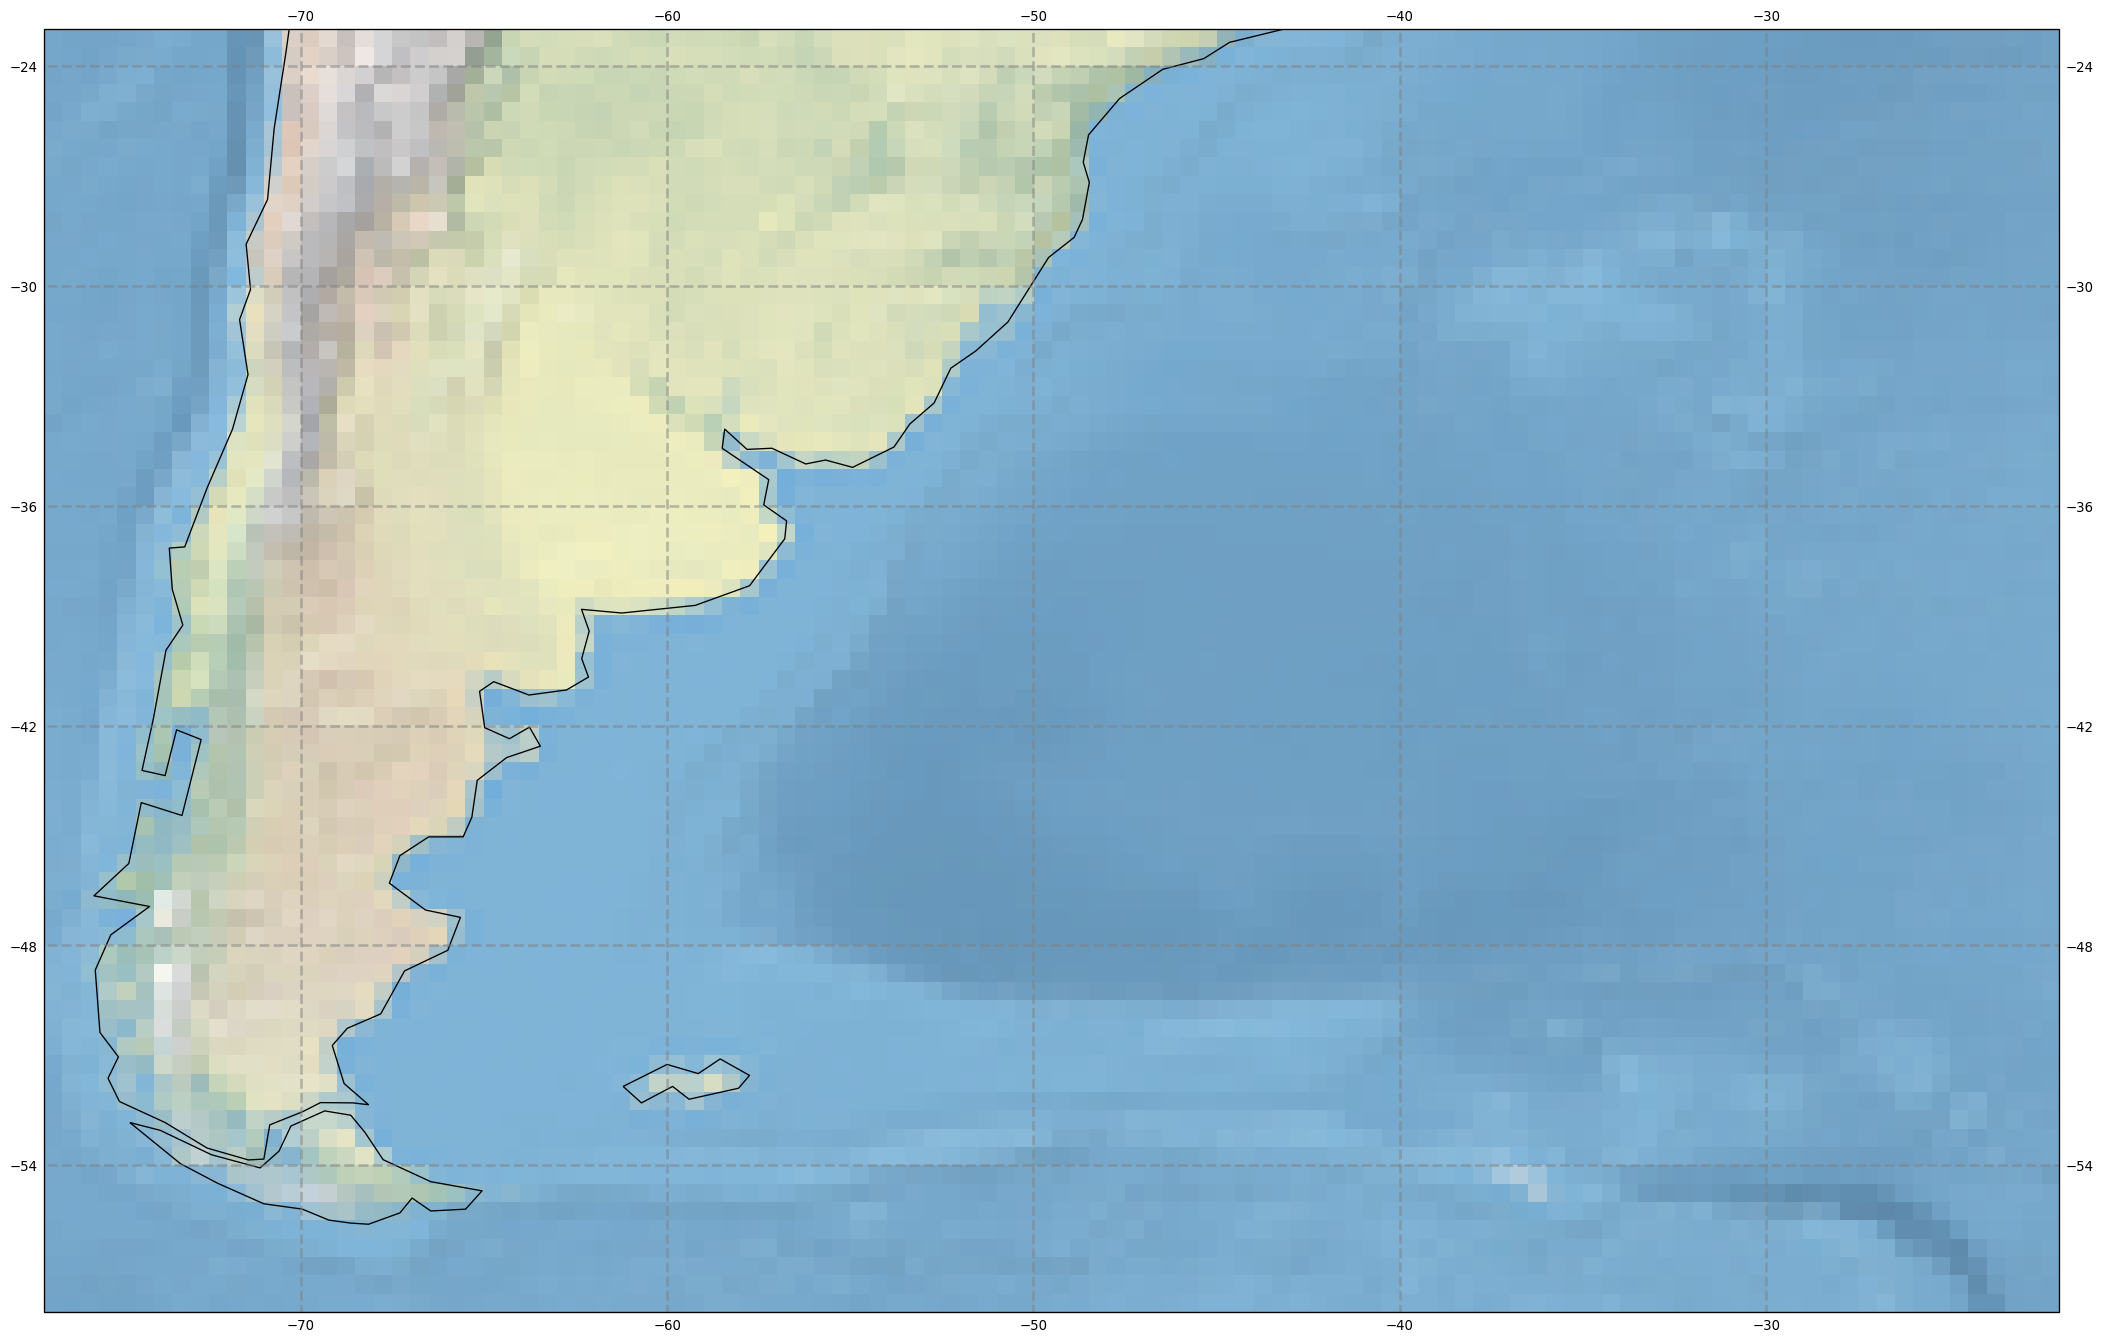

In [12]:
# Patagonia shelf
lon1 = -77
lon2 = -22
lat1 = -58
lat2 = -23

#World Map
mlon1 = -165
mlon2 = 180
mlat1 = -70
mlat2 = 75

# Get list of all vessels in region
unique_vessels = list(dat2['mmsi'].unique())

# Subset to allow for all segments even if outside of range
dat2 = dat2[dat2['mmsi'].isin(unique_vessels)]

dat2 = dat2[(dat2['lon'] >= lon1) & (dat2['lon'] <= lon2)]
dat2 = dat2[(dat2['lat'] >= lat1) & (dat2['lat'] <= lat2)]

#dat2 = dat2[(dat2['distance_from_shore_m'] > 0) ]
#dat2 = dat2[(dat2['distance_from_port_m'] > 0) ]

dat2['stationary'] = np.where(dat2['dist'] > 1, 0, 1)
dat2 = dat2[dat2['stationary'] == 0]

#dat2 = dat
my_dpi=96
fig = plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
             linewidth=2, color='gray', alpha=0.5, linestyle='--')

for mmsi, track in dat2.groupby('mmsi'):

    x = track.lon.values
    y = track.lat.values
    
    ax.plot(x, y, label=mmsi, transform=ccrs.PlateCarree())
    ax.plot(x, y, 'o', markersize=1, color = 'black', label=mmsi, transform=ccrs.PlateCarree())
    ax.plot(-77, -23, 'o', markersize=10, color = 'black', transform=ccrs.PlateCarree())
    ax.plot(-22, -23, 'o', markersize=10, color = 'black', transform=ccrs.PlateCarree())
    ax.plot(-77, -58, 'o', markersize=10, color = 'black', transform=ccrs.PlateCarree())
    ax.plot(-22, -58, 'o', markersize=10, color = 'black', transform=ccrs.PlateCarree())
    


In [114]:
# Puerto Madryn 
pdat = pd.read_feather('~/Data/GFW_point/Patagonia_Shelf/complete/Puerto_Madryn_2016-03-10_2016-03-20.feather')
print(len(pdat))

170967


In [96]:
# Puerto Mardryn Area
plon1 = -65.925222
plon2 = -54.418267
plat1 = -45
plat2 = -40

cdat = pd.read_csv('~/Projects/Patagonia-EDA/data/SA_coastlines.csv')

cdat = cdat[(cdat['lon'] >= plon1) & (cdat['lon'] <= plon2)]
cdat = cdat[(cdat['lat'] >= plat1) & (cdat['lat'] <= plat2)]

cdat['lon'] += 1
from shapely.geometry import Polygon, Point

# Create the filtering area (a polygon)
poly = Polygon(zip(cdat['lon'], cdat['lat']))

# Create a column converting your coordinates in point objects
pdat['point'] = pdat.apply(lambda x: Point(x.vessel_A_lon, x.vessel_A_lat), axis=1).values

# Apply the above mentioned method to get the index of the points within the filtering polygon
indices_within_region = pdat['point'].apply(lambda x: poly.intersects(x)).values

# Subset your df
pdat = pdat[~indices_within_region]
print(len(pdat))

#2016-03-10 01:00:00  204212000  204212000    -41.314444    -54.014629   

307794


In [78]:
print(f"lon: {min(cdat['lon'])}, {max(cdat['lon'])} lat: {min(cdat['lat'])},{max(cdat['lat'])}")

lon: -60.877222, -57.183889 lat: -44.999167,-40.002221999999996


[False False False ... False False False]


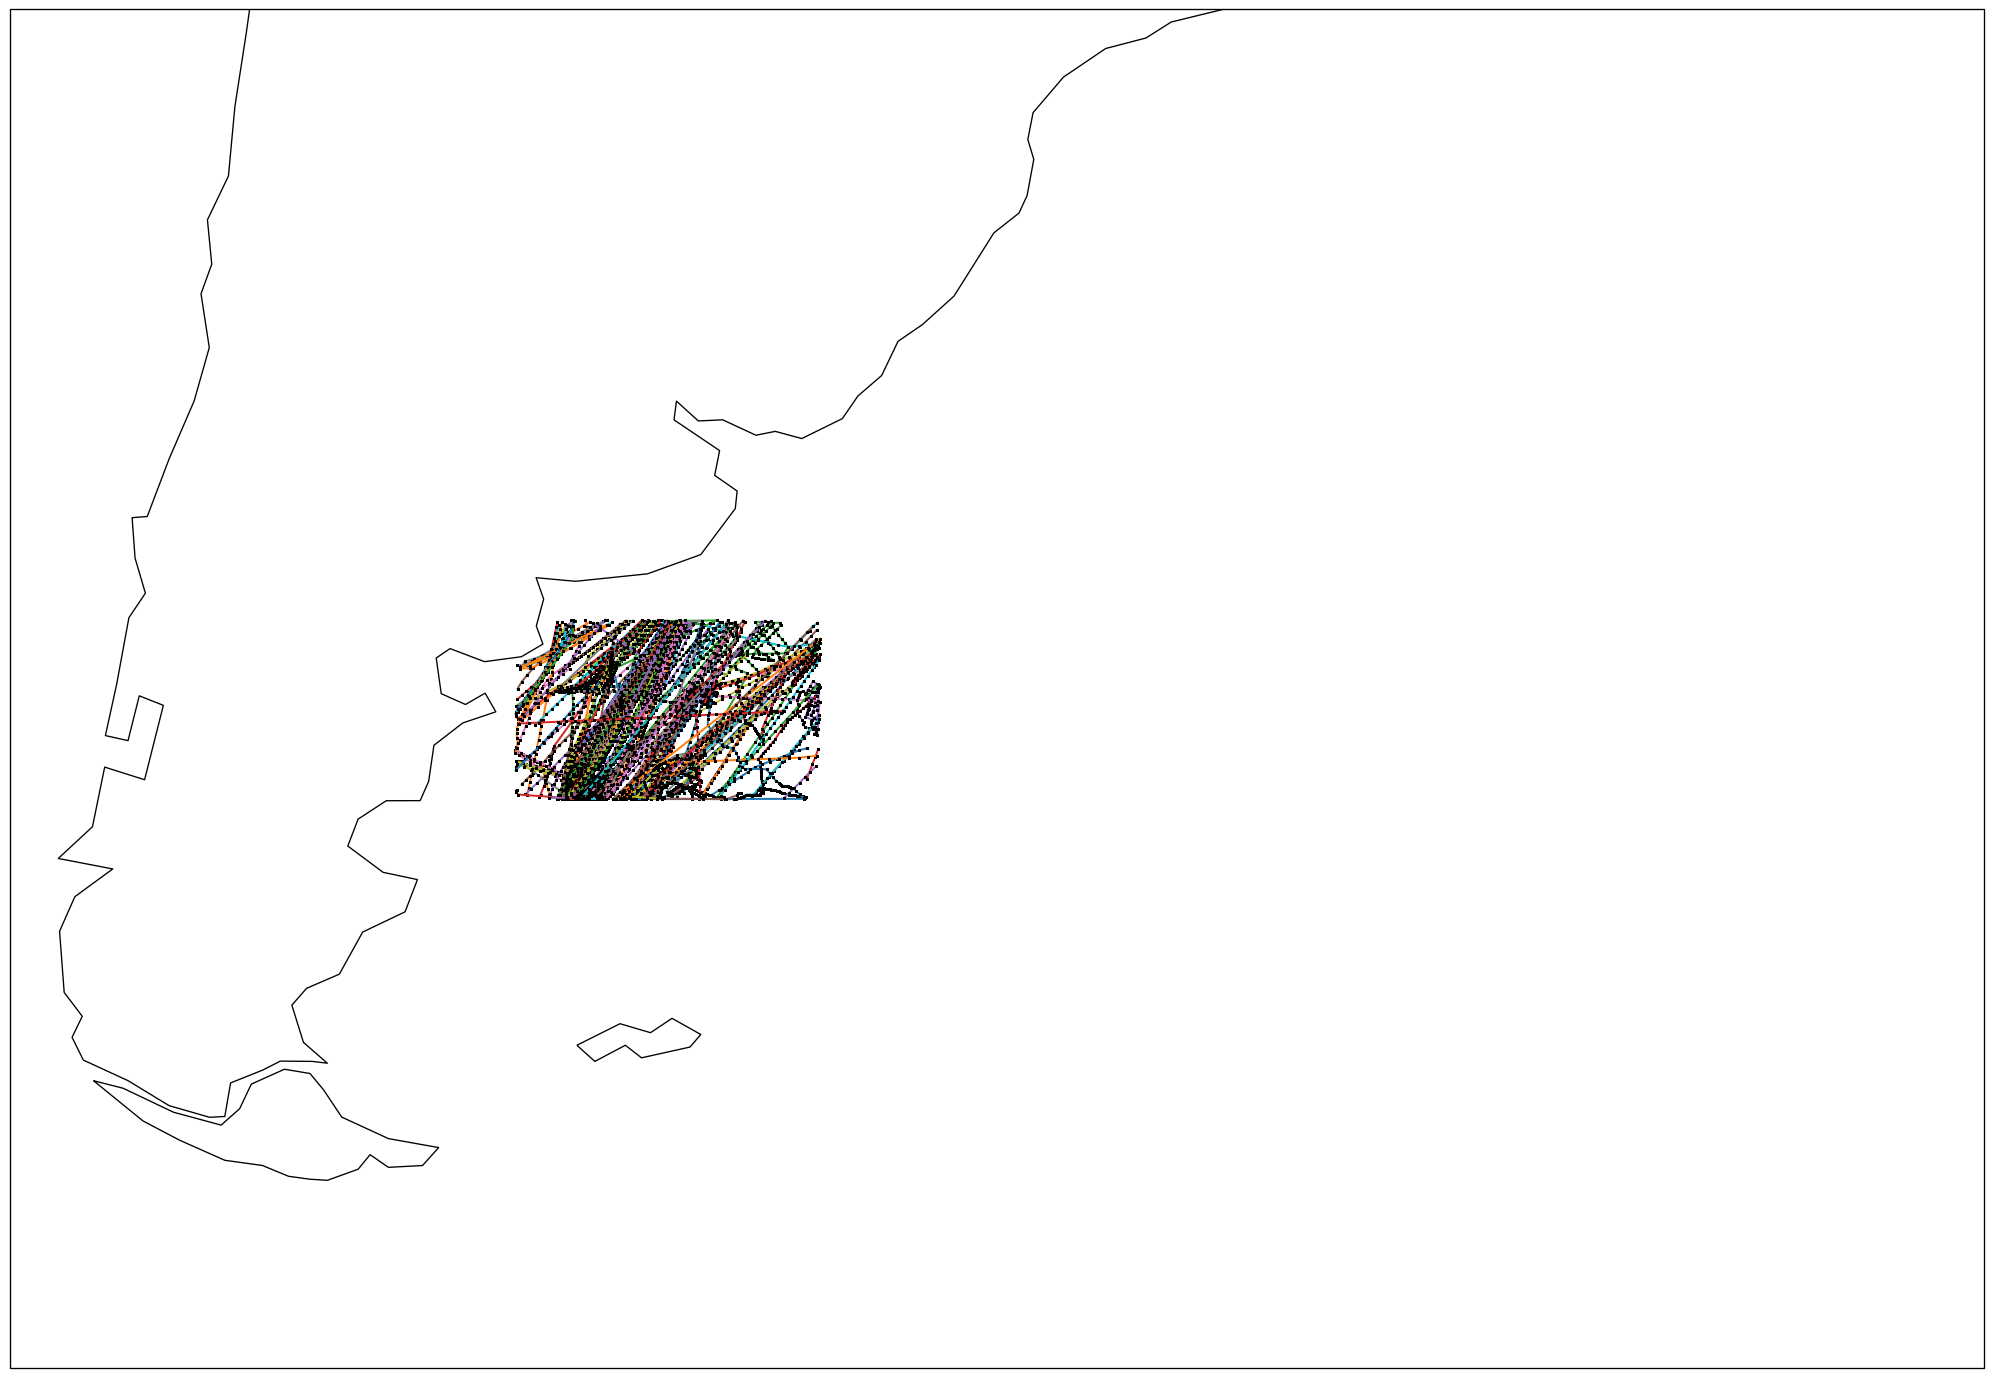

In [117]:
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(9, 13),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

# Patagonia shelf
lon1 = -77
lon2 = -22
lat1 = -58
lat2 = -23

#World Map
mlon1 = -165
mlon2 = 180
mlat1 = -70
mlat2 = 75

# Puerto Mardryn Area
plon1 = -62.925222
plon2 = -54.418267
plat1 = -45
plat2 = -40

mdat = pdat
mdat = mdat[(mdat['vessel_A_lon'] >= plon1) & (mdat['vessel_A_lon'] <= plon2)]
mdat = mdat[(mdat['vessel_A_lat'] >= plat1) & (mdat['vessel_A_lat'] <= plat2)]

# Specific time
my_dpi=96
#request = cimgt.OSM()
#fig, ax = make_map(projection=request.crs)

fig = plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.background_img(name='BM', resolution='low')
ax.set_extent([lon1, lon2, lat1, lat2])
ax.coastlines()
#ax.stock_img()


#tdat = mdat[mdat['timestamp'] == "2016-03-10 00:00:00"]
for mmsi, track in mdat.groupby('vessel_A'):

    x = track.vessel_A_lon.values
    y = track.vessel_A_lat.values
    
    ax.plot(x, y, label=mmsi, transform=ccrs.PlateCarree())
    ax.plot(x, y, 'o', markersize=1, color = 'black', label=mmsi, transform=ccrs.PlateCarree())

#ax.plot(cdat['lon'], cdat['lat'], 'o', markersize=1, color = 'red', transform=ccrs.PlateCarree())
#ax.plot(-25.463418, -24.623938, 'o', markersize=10, color = 'red', transform=ccrs.PlateCarree())
#ax.plot(pdat['lon'], pdat['lat'], label=mmsi, transform=ccrs.PlateCarree())
#ax.plot(pdat['lon'], pdat['lat'], 'o', markersize=1, color = 'red', label=mmsi, transform=ccrs.PlateCarree())




# ax.set_extent(extent)

# ax.add_image(request, 10)
# 
